### In this notebook, some functions are presented that eventually will be used later.

#### 1. Determining the distances between **labels** and **AP coordinates**

In [2]:
import os
import pandas as pd
from pathlib import Path
from typing import List

# Find project root (goes up from notebooks directory to thesis)
project_root = Path(os.path.abspath('')).parent

# Construct data path relative to project root
data_rssi_path = project_root / 'data' / 'test_data.csv'
data_ap_path = project_root / 'data' / 'AP_crd.csv'

# Read the CSV file (test data)
df_test = pd.read_csv(data_rssi_path)
# Replace RSSI values equal to 100 with -100
df_test = df_test.replace(100, -100)
# Read the AP coordinates CSV file
df_AP = pd.read_csv(data_ap_path)

def get_distances(df: pd.DataFrame, ap_df: pd.DataFrame, H: float) -> List[dict]:
    """
    Calculate distances from all AP coordinates to each point in the DataFrame.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing position data with X, Y coordinates and LABEL
    ap_df : pandas.DataFrame
        DataFrame containing AP coordinates with columns 'AP', 'X', 'Y'
    H: float
        Height offset to be added to the Euclidean distance calculation
    Returns:
    --------
    list of dictionaries
        Each dictionary corresponds to a row in df, where:
        - keys are WAP identifiers
        - values are Euclidean distances from the point to each WAP
    """
    # Get all WAP columns from the test dataframe
    wap_columns = [col for col in df.columns if col.startswith('WAP')]

    # Create a mapping of WAP names to their coordinates
    ap_coords = {}
    for _, row in ap_df.iterrows():
        ap_name = row['AP']
        if ap_name in wap_columns:  # Only include APs that exist in the test data
            ap_coords[ap_name] = (row['x'], row['y'])

    # Calculate distances for each point
    distances_list = []
    for _, row in df.iterrows():
        point_coords = (row['X'], row['Y'])

        # Calculate distance to each AP
        distances = {}
        for wap_name in wap_columns:
            if wap_name in ap_coords:
                # Euclidean distance calculation
                ap_x, ap_y = ap_coords[wap_name]
                distance = ((point_coords[0] - ap_x) ** 2 + (point_coords[1] - ap_y) ** 2 + H ** 2) ** 0.5
                distances[wap_name] = round(distance, 2)
            else:
                # Handle missing AP coordinates
                distances[wap_name] = None

        distances_list.append(distances)

    return distances_list


Usage Example:

In [3]:
# Calculate distances for each point to all APs
distances = get_distances(df_test, df_AP, H=2)

# Print the first few results
print(f"Number of points processed: {len(distances)}")
print(f"Sample of first point distances: {list(distances[0].items())[:5]}")

# Add distances as a new column to the dataframe if needed
df_test['distances'] = distances

Number of points processed: 1420
Sample of first point distances: [('WAP96', 2.06), ('WAP100', 31.72), ('WAP101', 16.98), ('WAP102', 6.76), ('WAP104', 26.69)]


#### 2. Expected RSSI with log-distance path loss model

In [4]:
from typing import TypedDict
import numpy as np

class LogParams(TypedDict):
    rho_0: float  # Signal path loss at the reference distance of 1 meter
    alpha: float  # Path loss exponent

def expected_rssi(distances: List[dict], df_ap: pd.DataFrame, log_params: LogParams) -> pd.DataFrame:
    """
    Calculate expected RSSI values based on distances to APs.

    Parameters:
    -----------
    distances : list of dict
        List of dictionaries containing distances to each AP for each point
    df_ap : pandas.DataFrame
        DataFrame containing AP coordinates and their RSSI values
    log_params : LogParams
        Dictionary containing parameters for the log-distance path loss model, including:
        - 'rho_0': Signal path loss at the reference distance of 1 meter
        - 'alpha': Path loss exponent
    Returns:
    --------
    pandas.DataFrame
        DataFrame with expected RSSI values added for each point
    """
    # Create a new DataFrame to hold the distances
    rssi_df = pd.DataFrame(distances)

    # Iterate through the rssi_df and calculate expected RSSI (each distance is substituted with the corresponding RSSI value)
    for wap in rssi_df.columns:
        if wap in df_ap['AP'].values:
            # Replace distances with expected RSSI values
            rssi_df[wap] = - log_params['rho_0'] - 10 * log_params['alpha'] * np.log10(rssi_df[wap])
            # Round the expected RSSI values to 2 decimal places
            rssi_df[wap] = rssi_df[wap].round(2)
    # Replace all rssi values less or equal to -100 with -100
    rssi_df = rssi_df.clip(lower=-100, upper=None)

    # Add the LABEL column from the original DataFrame
    rssi_df['LABEL'] = df_test['LABEL'].values
    # Add the DEVICE column from the original DataFrame
    rssi_df['DEVICE'] = df_test['DEVICE'].values
    # Add the X and Y coordinates from the original DataFrame
    rssi_df['X'] = df_test['X'].values
    rssi_df['Y'] = df_test['Y'].values

    return rssi_df

- Example of dataframe visualization

In [5]:
expected_rssi_df = expected_rssi(distances, df_AP, log_params={'rho_0': 60, 'alpha': 3.5})
expected_rssi_df[:10]

,WAP96,WAP100,WAP101,WAP102,WAP104,WAP105,WAP106,WAP107,WAP108,WAP112,WAP114,WAP115,WAP116,WAP117,WAP118,LABEL,DEVICE,X,Y
0,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,1002,1.5,10.2
1,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,104D,1.5,10.2
2,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,10CE,1.5,10.2
3,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,1210,1.5,10.2
4,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,1211,1.5,10.2
5,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,121D,1.5,10.2
6,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,1F61,1.5,10.2
7,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,2005,1.5,10.2
8,-70.99,-100.0,-100.0,-89.05,-100.0,-89.64,-100.0,-100.0,-100.0,-100.0,-100.0,-92.11,-100.0,-100.0,-97.41,1611,2055,1.5,10.2
9,-75.49,-100.0,-100.0,-93.18,-100.0,-84.52,-100.0,-100.0,-100.0,-100.0,-100.0,-94.79,-100.0,-100.0,-97.97,1613,1002,1.5,12.5


#### 3. Nearest-Neighbor (NN) based on test dataframe and expected RSSI dataframe (as the training data)

In [7]:
from sklearn.metrics.pairwise import euclidean_distances
from typing import List, Dict, Tuple, Union

def nearest_neighbor_positioning(
    test_df: pd.DataFrame,
    expected_rssi_df: pd.DataFrame,
    device_column: str = 'DEVICE',
    label_column: str = 'LABEL',
    rssi_threshold: float = None
) -> List[Dict[str, Union[int, float, Tuple[float, float]]]]:
    """
    Estimates positions using nearest-neighbor algorithm comparing RSSI values.

    Parameters:
    -----------
    test_df : pandas.DataFrame
        DataFrame containing test RSSI values and true positions
    expected_rssi_df : pandas.DataFrame
        DataFrame with expected RSSI values based on log-distance model
    device_column : str
        Name of the column containing device identifiers
    label_column : str
        Name of the column containing location labels
    rssi_threshold : float
        Threshold for RSSI values to consider (default is 0.0)
    Returns:
    --------
    list of dict
        Each dictionary contains:
        - 'true_label': The actual label from test_df
        - 'estimated_label': The predicted label based on nearest neighbor
        - 'true_coords': (x, y) coordinates of the true position
        - 'estimated_coords': (x, y) coordinates of the estimated position
        - 'error_distance': Euclidean distance between true and estimated positions
        - 'device': Device identifier
        - 'num_valid_waps': Number of valid WAPs (those with RSSI above the threshold)
    """
    # Get WAP columns (RSSI values)
    wap_columns = [col for col in test_df.columns if col.startswith('WAP')]

    # Results list
    results = []

    # Process each test point
    for idx, test_row in test_df.iterrows():
        # Get the device for this test point
        device = test_row[device_column]

        # Filter expected RSSI dataframe for this device
        device_expected_rssi = expected_rssi_df[expected_rssi_df[device_column] == device].copy()

        if device_expected_rssi.empty:
            print(f"Warning: No data for device {device} in expected RSSI dataframe")
            continue

        # Extract RSSI values from test point
        test_rssi = test_row[wap_columns].values

        if rssi_threshold is not None:
            # Create a mask for RSSI values above the threshold
            valid_wap_mask = test_rssi > rssi_threshold

            # Skip if no valid WAPs are found
            if np.sum(valid_wap_mask) == 0:
                print(f"Warning: No valid WAPs with RSSI > {rssi_threshold} for point {idx}")
                # Use a fallback approach or skip this point
                # Here we'll use all WAPs as a fallback
                valid_wap_mask = np.ones(len(wap_columns), dtype=bool)
        else:
            # If no threshold is set, consider all WAPs valid
            valid_wap_mask = np.ones(len(wap_columns), dtype=bool)

        # Count valid WAPs
        num_valid_waps = np.sum(valid_wap_mask)

        # Apply the mask to get only valid WAPs
        filtered_test_rssi = test_rssi[valid_wap_mask].reshape(1, -1)

       # Get the column names of valid WAPs
        valid_wap_columns = [wap_columns[i] for i in range(len(wap_columns)) if valid_wap_mask[i]]

        # Extract RSSI values from filtered expected dataframe
        train_rssi = device_expected_rssi[valid_wap_columns].values

        # Calculate distances between test point and all expected points
        distances = euclidean_distances(filtered_test_rssi, train_rssi)[0]

        # Find the nearest neighbor
        nearest_idx = np.argmin(distances)
        estimated_label = device_expected_rssi.iloc[nearest_idx][label_column]

        # Get coordinates
        true_coords = (test_row['X'], test_row['Y'])
        estimated_coords = (device_expected_rssi.iloc[nearest_idx]['X'].round(1),
                            device_expected_rssi.iloc[nearest_idx]['Y'].round(1))

        # Calculate positioning error
        error_distance = np.sqrt((true_coords[0] - estimated_coords[0])**2 +
                                 (true_coords[1] - estimated_coords[1])**2).round(2)

        # Store results
        results.append({
            'true_label': test_row[label_column],
            'estimated_label': estimated_label,
            'true_coords': (round(true_coords[0], 1), round(true_coords[1], 1)),
            'estimated_coords': estimated_coords,
            'error_distance': round(error_distance, 2),
            'device': device,
            'num_valid_waps': num_valid_waps  # Count valid WAPs
        })

    return results

- Usage Example:

In [8]:
# Calculate expected RSSI values based on distances to APs
expected_rssi_df = expected_rssi(distances, df_AP, log_params={'rho_0': 55, 'alpha': 4.2})


# Run the nearest-neighbor algorithm
positioning_results = nearest_neighbor_positioning(df_test, expected_rssi_df)

# Create a DataFrame from the results for easier analysis
results_df = pd.DataFrame(positioning_results)

# Calculate overall performance metrics
avg_error = results_df['error_distance'].mean().round(2)
median_error = results_df['error_distance'].median().round(2)
max_error = results_df['error_distance'].max()

# Room accuracy: the first two digits are used to estimate the room label (the format is '1611' or '16123')
results_df['estimated_room_label'] = results_df['estimated_label'].astype(str).str[:2]  # Extract room label from estimated label
results_df['true_room_label'] = results_df['true_label'].astype(str).str[:2]  # Extract room label from true label
# Calculate accuracy as the percentage of correctly estimated labels
accuracy = (results_df['true_room_label'] == results_df['estimated_room_label']).mean() * 100

print(f"Average positioning error: {avg_error:.2f} meters")
print(f"Median positioning error: {median_error:.2f} meters")
print(f"Maximum positioning error: {max_error:.2f} meters")
print(f"Room accuracy: {accuracy:.2f}%")

# Calculate device-specific performance
device_performance = results_df.groupby('device').agg({
    'error_distance': ['mean', 'median', 'max'],
    'true_room_label': lambda x: (x == results_df.loc[x.index, 'estimated_room_label']).mean() * 100
})

print("\nDevice-specific performance:")
print(device_performance)

Average positioning error: 2.89 meters
Median positioning error: 2.48 meters
Maximum positioning error: 9.23 meters
Room accuracy: 76.69%

Device-specific performance:
       error_distance              true_room_label
                 mean median   max        <lambda>
device                                            
1002         2.808298  2.480  7.57       78.723404
104D         2.975147  2.935  8.42       76.470588
10CE         2.969315  2.480  9.23       78.767123
1210         2.897133  2.480  8.68       75.524476
1211         2.988676  3.010  8.35       75.735294
1212         3.075390  2.690  7.71       73.758865
121D         2.879456  2.300  7.72       72.789116
1F61         2.735139  2.300  7.71       80.555556
2005         2.717241  2.300  6.60       80.000000
2055         2.868440  2.700  7.18       74.468085


In [9]:
avg_error_1210 = results_df[results_df['device'] == '1210']['error_distance'].mean().round(2)
print(f"\nAverage error for device 1210: {avg_error_1210:.2f} meters")


Average error for device 1210: 2.90 meters


In [10]:
nn_error = results_df[results_df['device'] == '1210']['error_distance']
len(nn_error)
type(nn_error)

pandas.core.series.Series

#### 4. Optimization Algorithms for Implementation

4.1 Utils

In [11]:
def objective_function(params: List[float], df_AP: pd.DataFrame, test_rssi: Dict[str, float], H: float=2) -> float:
    """
    Objective function to minimize the difference between expected and actual RSSI values.

    Parameters:
    -----------
    params : list
        List of parameters [x, y, rho_0, alpha] to be minimized. x, y are the coordinates of the point to estimate,
        rho_0 is the signal path loss at 1 meter, and alpha is the path loss exponent.
    df_AP : pandas.DataFrame
        DataFrame containing AP coordinates and their RSSI values
    test_rssi : List[float]
        List of actual RSSI values for the test point

    Returns:
    --------
    float
        The sum of squared differences between expected and actual RSSI values
    """
    x, y, rho_0, alpha = params
    total_error = 0.0

    # Iterate through the test_rssi values and the AP coordinates
    for wap, rssi in test_rssi.items():
        # Skip WAPs that don't have corresponding coordinates in df_AP or have RSSI values of -100
        if wap not in df_AP['AP'].values or rssi <= -100:
            continue

        # Get the coordinates of the current AP
        ap_x = df_AP.loc[df_AP['AP'] == wap, 'x'].values[0]
        ap_y = df_AP.loc[df_AP['AP'] == wap, 'y'].values[0]

        # Calculate the distance from the proposed position to the current AP
        distance = np.sqrt((x - ap_x)**2 + (y - ap_y)**2 + H**2)

        # Calculate expected RSSI using the log-distance path loss model
        expected_rssi = -rho_0 - 10 * alpha * np.log10(distance)

        # Clip the expected RSSI to -100 if it's lower
        expected_rssi = max(expected_rssi, -100)

        # Calculate the squared error (difference from actual RSSI)
        error = (expected_rssi - rssi) ** 2

        # Add to the total error
        total_error += error
    # Return the total error (to be minimized)
    return total_error

def circle_constraint(params: List[float], radius: float, nn_coords: Tuple[float]) -> float:
    """
    Constraint function to ensure the estimated point is within a circle of given radius.

    Parameters:
    -----------
    params : list
        List of parameters [x, y, rho_0, alpha]
    radius : float
        Radius of the circle
    nn_coords : tuple
        Tuple containing (x_nn, y_nn) coordinates of the nearest neighbors

    Returns:
    --------
    float
        The distance from the origin minus the radius (should be <= 0)
    """
    x, y, _, _ = params
    x_c = nn_coords[0]
    y_c = nn_coords[1]
    # Calculate the squared distance from the center of the circle
    return (x - x_c)**2 + (y - y_c)**2 - radius**2

def extract_rssi_dicts(df: pd.DataFrame) -> List[Dict[str, float]]:
    """
    Extract RSSI values from a DataFrame into a list of dictionaries.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing RSSI values in columns starting with 'WAP'

    Returns:
    --------
    List[Dict[str, float]]
        List of dictionaries, where each dictionary contains:
        - keys: WAP identifiers
        - values: corresponding RSSI values
    """
    # Get all WAP columns
    wap_columns = [col for col in df.columns if col.startswith('WAP')]

    # Initialize the list to hold the dictionaries
    rssi_dicts = []

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        # Create a dictionary for this row's RSSI values
        rssi_dict = {}
        for wap in wap_columns:
            # Only include non-null values
            if pd.notnull(row[wap]):
                rssi_dict[wap] = float(row[wap])

        # Add the dictionary to the list
        rssi_dicts.append(rssi_dict)

    return rssi_dicts

4.2. Functions to optimize a single position using the optimization algorithms. Here is a list of them:
- Differential Evolution;
- Particle Swarm Optimization;
- Simulated Annealing;
- L-BFGS-B;
- TRCA;
- SLSQP.

In [12]:
# Optimization Algorithms
from scipy.optimize import (differential_evolution, # Differential Evolution
                                dual_annealing, # Simulated Annealing
                                minimize, # L-BFGS-B, TRCA and SLSQP
                                NonlinearConstraint
                            )
from functools import partial
# Particle Swarm Optimization
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.functions import single_obj as fx


def optimize_position_de(test_rssi: Dict[str, float],
                         df_AP: pd.DataFrame,
                         nn_coords: Tuple[float],
                         radius: float = 1.0,
                         log_params: LogParams = {'rho_0': 60, 'alpha': 3.5}) -> List[float]:
    """
    Optimize the position of a point based on RSSI values using differential evolution.

    Parameters:
    -----------
    test_rssi : dict
        Dictionary containing actual RSSI values for the test point
    df_AP : pandas.DataFrame
        DataFrame containing AP coordinates and their RSSI values
    nn_coords : tuple
        Tuple containing (x_nn, y_nn) coordinates of the nearest neighbors
    radius : float
        Radius of the circle constraint

    Returns:
    --------
    list
        Optimized parameters [x, y, rho_0, alpha]
    """
    # Initial guess for the parameters: [x, y, rho_0, alpha]
    initial_guess = [nn_coords[0], nn_coords[1], log_params['rho_0'], log_params['alpha']]

    # Create a partial function with radius and nn_coords pre-specified
    constrained_circle = partial(circle_constraint, radius=radius, nn_coords=nn_coords)

    # Define the constraint for the circle
    circle_constr = NonlinearConstraint(constrained_circle, -np.inf, 0.0)

    # Perform differential evolution optimization
    result = differential_evolution(
        objective_function,
        bounds=[(0, 44), (1.5, 15), (40, 80), (1, 7)],
        args=(df_AP, test_rssi),
        # x0=initial_guess,
        constraints=[circle_constr],
        maxiter=100,
        popsize=15,
        tol=1e-6,
        disp=False,
        polish=False, # Disable polishing for faster convergence
        workers=1 # Use all available CPU cores
    )

    return result.x.tolist()

def optimize_position_pso(test_rssi: Dict[str, float], df_AP: pd.DataFrame, nn_coords: Tuple[float], radius: float = 2.0, log_params: LogParams = {'rho_0': 60, 'alpha': 3.5}) -> List[float]:
    """
    Optimize position using Particle Swarm Optimization.

    Parameters:
    -----------
    test_rssi : dict
        Dictionary containing actual RSSI values for the test point
    df_AP : pandas.DataFrame
        DataFrame containing AP coordinates and their RSSI values
    nn_coords : tuple
        Tuple containing (x_nn, y_nn) coordinates of the nearest neighbors
    radius : float
        Radius of the search space around nn_coords

    Returns:
    --------
    list
        Optimized parameters [x, y, rho_0, alpha]
    """
    # Define objective function for PSO
    def pso_objective(params):
        # Reshape params to handle multiple particles
        results = []
        for param in params:
            x, y, rho_0, alpha = param

            # Apply circle constraint - if outside radius, apply penalty
            if ((x - nn_coords[0])**2 + (y - nn_coords[1])**2) > radius**2:
                results.append(1e6)  # Large penalty
                continue

            # Calculate objective function value
            results.append(objective_function([x, y, rho_0, alpha], df_AP, test_rssi))
        return np.array(results)

    # Set bounds: x, y, rho_0, alpha
    lower_bounds = [max(0, nn_coords[0] - radius), max(0, nn_coords[1] - radius), 40, 1]
    upper_bounds = [min(44, nn_coords[0] + radius), min(15, nn_coords[1] + radius), 80, 7]
    bounds = (lower_bounds, upper_bounds)

    # Initialize swarm
    options = {'c1': 0.4, 'c2': 0.4, 'w': 0.55}
    optimizer = GlobalBestPSO(n_particles=100, dimensions=4, options=options, bounds=bounds)

    # Perform optimization
    best_cost, best_pos = optimizer.optimize(pso_objective, iters=5)

    return best_pos.tolist()

def optimize_position_sa(test_rssi: Dict[str, float],
                         df_AP: pd.DataFrame,
                         nn_coords: Tuple[float],
                         radius: float = 2.0,
                         log_params: LogParams = {'rho_0': 60, 'alpha': 3.5}) -> List[float]:
    """
    Optimize position using Simulated Annealing.

    Parameters:
    -----------
    test_rssi : dict
        Dictionary containing actual RSSI values for the test point
    df_AP : pandas.DataFrame
        DataFrame containing AP coordinates and their RSSI values
    nn_coords : tuple
        Tuple containing (x_nn, y_nn) coordinates of the nearest neighbors
    radius : float
        Radius of the search space around nn_coords

    Returns:
    --------
    list
        Optimized parameters [x, y, rho_0, alpha]
    """
    # Create a wrapped objective function with circle constraint
    def constrained_objective(params):
        x, y, rho_0, alpha = params

        # Check if the point is within the circle
        if ((x - nn_coords[0])**2 + (y - nn_coords[1])**2) > radius**2:
            return 1e6  # Large penalty

        return objective_function(params, df_AP, test_rssi)

    # Bounds for the parameters
    bounds = [(0, 44), (1.5, 15), (40, 80), (1, 7)]

    # Run simulated annealing
    result = dual_annealing(
        constrained_objective,
        bounds,
        maxiter=100,
        initial_temp=5230.0,
        restart_temp_ratio=2e-5,
        visit=2.62,
        accept=-5.0,
        maxfun=1e7
    )

    return result.x.tolist()

def optimize_position_bfgs(test_rssi: Dict[str, float], df_AP: pd.DataFrame,
                           nn_coords: Tuple[float],
                           radius: float = 2.0,
                           log_params: LogParams = {'rho_0': 60, 'alpha': 3.5}) -> List[float]:
    """
    Optimize position using BFGS algorithm.

    Parameters:
    -----------
    test_rssi : dict
        Dictionary containing actual RSSI values for the test point
    df_AP : pandas.DataFrame
        DataFrame containing AP coordinates and their RSSI values
    nn_coords : tuple
        Tuple containing (x_nn, y_nn) coordinates of the nearest neighbors
    radius : float
        Radius of the search space around nn_coords

    Returns:
    --------
    list
        Optimized parameters [x, y, rho_0, alpha]
    """
    # Create a wrapped objective function with circle constraint
    def constrained_objective(params):
        x, y, rho_0, alpha = params

        # Check if the point is within the circle
        if ((x - nn_coords[0])**2 + (y - nn_coords[1])**2) > radius**2:
            return 1e6  # Large penalty

        return objective_function(params, df_AP, test_rssi)

    # Initial guess at the nearest neighbor position with typical model parameters
    initial_guess = [nn_coords[0], nn_coords[1], log_params['rho_0'], log_params['alpha']]

    # Bounds for the parameters
    bounds = [(0, 44), (1.5, 15), (40, 80), (1, 7)]

    # Run BFGS
    result = minimize(
        constrained_objective,
        initial_guess,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 100}
    )

    return result.x.tolist()

def optimize_position_trca(test_rssi: Dict[str, float],
                           df_AP: pd.DataFrame, nn_coords: Tuple[float],
                           radius: float = 2.0,
                           log_params: LogParams = {'rho_0': 60, 'alpha': 3.5}) -> List[float]:
    """
    Optimize position using Trust Region Constrained Algorithm.

    Parameters:
    -----------
    test_rssi : dict
        Dictionary containing actual RSSI values for the test point
    df_AP : pandas.DataFrame
        DataFrame containing AP coordinates and their RSSI values
    nn_coords : tuple
        Tuple containing (x_nn, y_nn) coordinates of the nearest neighbors
    radius : float
        Radius of the search space around nn_coords

    Returns:
    --------
    list
        Optimized parameters [x, y, rho_0, alpha]
    """
    # Create a partial function with radius and nn_coords pre-specified
    constrained_circle = partial(circle_constraint, radius=radius, nn_coords=nn_coords)

    # Define the constraint for the circle
    circle_constr = NonlinearConstraint(constrained_circle, -np.inf, 0.0)

    # Create a wrapped objective function with circle constraint
    def constrained_objective(params):
        x, y, rho_0, alpha = params

        # # Check if the point is within the circle
        # if ((x - nn_coords[0])**2 + (y - nn_coords[1])**2) > radius**2:
        #     return 1e6  # Large penalty

        return objective_function(params, df_AP, test_rssi)

    # Initial guess at the nearest neighbor position with typical model parameters
    initial_guess = [nn_coords[0], nn_coords[1], log_params['rho_0'], log_params['alpha']]

    # Bounds for the parameters
    bounds = [(0, 44), (1.5, 15), (40, 80), (1, 7)]

    # Run BFGS
    result = minimize(
        constrained_objective,
        initial_guess,
        method='trust-constr',
        constraints=[circle_constr],
        bounds=bounds,
        options={'maxiter': 100}
    )

    return result.x.tolist()

def optimize_position_slsqp(test_rssi: Dict[str, float],
                            df_AP: pd.DataFrame,
                            nn_coords: Tuple[float],
                            radius: float = 2.0,
                            log_params: LogParams = {'rho_0': 60, 'alpha': 3.5}) -> List[float]:
    """
    Optimize position using Sequential Least Squares Programming (SLSQP) algorithm.

    Parameters:
    -----------
    test_rssi : dict
        Dictionary containing actual RSSI values for the test point
    df_AP : pandas.DataFrame
        DataFrame containing AP coordinates and their RSSI values
    nn_coords : tuple
        Tuple containing (x_nn, y_nn) coordinates of the nearest neighbors
    radius : float
        Radius of the search space around nn_coords
    log_params : LogParams
        Dictionary containing parameters for the log-distance path loss model, including:
        - 'rho_0': Signal path loss at the reference distance of 1 meter
        - 'alpha': Path loss exponent
        These parameters are used as initial guesses for the optimization.

    Returns:
    --------
    list
        Optimized parameters [x, y, rho_0, alpha]
    """
    # Create partial function for constraint
    constrained_circle = partial(circle_constraint, radius=radius, nn_coords=nn_coords)
    circle_constr = NonlinearConstraint(constrained_circle, -np.inf, 0.0)

    # Initial guess
    initial_guess = [nn_coords[0], nn_coords[1], log_params['rho_0'], log_params['alpha']]

    # Bounds
    bounds = [(0, 44), (1.5, 15), (40, 80), (1, 7)]

    # Use a different optimization method
    result = minimize(
        lambda params: objective_function(params, df_AP, test_rssi),
        initial_guess,
        method='SLSQP',  # Try SLSQP instead of trust-constr
        bounds=bounds,
        constraints=[circle_constr],
        options={'maxiter': 100, 'disp': False}
    )

    return result.x.tolist()

4.3. Position estimation considering the whole set of testing points by DEVICE

In [13]:
def estimate_position_with_optimizer(df_test, df_AP, df_expected_rssi, optimizer_func, radius=2.0, log_params: LogParams = {'rho_0': 60, 'alpha': 3.5}):
    """
    Estimate positions using the specified optimization algorithm.

    Parameters:
    -----------
    df_test : pandas.DataFrame
        DataFrame containing test RSSI values and true positions
    df_AP : pandas.DataFrame
        DataFrame with AP coordinates and their RSSI values
    df_expected_rssi : pandas.DataFrame
        DataFrame with expected RSSI values based on log-distance model
    optimizer_func : function
        The optimization function to use (e.g., optimize_position, optimize_position_pso)
    radius : float
        Radius for the circle constraint in the optimization
    log_params : LogParams
        Dictionary containing parameters for the log-distance path loss model, including:
        - 'rho_0': Signal path loss at the reference distance of 1 meter
        - 'alpha': Path loss exponent

    Returns:
    --------
    list of dict
        Each dictionary contains:
        - 'true_label': The actual label from df_test
        - 'estimated_coords': (x, y) coordinates of the estimated position
        - 'error_distance': Euclidean distance between true and estimated positions
        - 'device': Device identifier
        - 'optimizer': Name of the optimization function used
    """
    results = []
    # List of estimated positions using nearest neighbors
    nn_positioning_list = nearest_neighbor_positioning(df_test, df_expected_rssi)
    nn_coords_list = [(result['estimated_coords'][0], result['estimated_coords'][1]) for result in nn_positioning_list]

    # List of RSSI dictionaries for the test points
    test_rssi_dicts = extract_rssi_dicts(df_test)
    idx_count = 0

    # Iterate through each test point
    for idx, test_row in df_test.iterrows():
        device = test_row['DEVICE']
        test_rssi = test_rssi_dicts[idx_count]

        # Get nearest neighbor coordinates for the current test point
        nn_coords = nn_coords_list[idx_count]

        # Optimize position using the specified algorithm
        optimized_params = optimizer_func(test_rssi, df_AP, nn_coords, radius, log_params)

        # Extract estimated coordinates from optimized parameters
        estimated_coords = (optimized_params[0], optimized_params[1])

        # Calculate positioning error
        true_coords = (test_row['X'], test_row['Y'])
        error_distance = np.sqrt((true_coords[0] - estimated_coords[0])**2 +
                               (true_coords[1] - estimated_coords[1])**2).round(2)

        # Store results
        results.append({
            'true_label': test_row['LABEL'],
            'estimated_coords': estimated_coords,
            'error_distance': round(error_distance, 2),
            'device': device,
            'optimizer': optimizer_func.__name__
        })

        # Increment index count
        idx_count += 1

    return results

- Usage example

In [12]:
final_positioning_list = estimate_position_with_optimizer(
    df_test=df_test[df_test['DEVICE'] == '1210'],
    df_expected_rssi=expected_rssi_df[expected_rssi_df['DEVICE'] == '1210'],
    optimizer_func=optimize_position_slsqp,  # Change to desired optimizer function
    df_AP=df_AP,
    radius=2.0,
    log_params={'rho_0': 60, 'alpha': 3.5})

- Displaying the results using the list of final positioning estimations

In [13]:
# Extract error distances and calculate mean
mean_error = sum([result['error_distance'] for result in final_positioning_list]) / len(final_positioning_list)
print(f"Mean positioning error: {mean_error:.2f} meters")

# You can also calculate other statistics
median_error = sorted([result['error_distance'] for result in final_positioning_list])[len(final_positioning_list)//2]
max_error = max([result['error_distance'] for result in final_positioning_list])

print(f"Median positioning error: {median_error:.2f} meters")
print(f"Maximum positioning error: {max_error:.2f} meters")

Mean positioning error: 2.69 meters
Median positioning error: 2.32 meters
Maximum positioning error: 9.91 meters


- Converting to DataFrame for more analysis

In [14]:
# Convert the results list to a DataFrame for easier analysis
results_df = pd.DataFrame(final_positioning_list)

# Calculate error statistics
mean_error = results_df['error_distance'].mean().round(2)
median_error = results_df['error_distance'].median().round(2)
max_error = results_df['error_distance'].max()

print(f"Mean positioning error: {mean_error:.2f} meters")
print(f"Median positioning error: {median_error:.2f} meters")
print(f"Maximum positioning error: {max_error:.2f} meters")

# You can also analyze by groups if needed
device_stats = results_df.groupby('device')['error_distance'].agg(['mean', 'median', 'max', 'count'])
print("\nDevice-specific performance:")
print(device_stats)

Mean positioning error: 2.69 meters
Median positioning error: 2.32 meters
Maximum positioning error: 9.91 meters

Device-specific performance:
            mean  median   max  count
device                               
1210    2.691259    2.32  9.91    143


#### 5. Parallelization Approach

In [14]:
def process_single_point_with_optimizer(args):
    """Process a single test point for position estimation with DE."""
    idx, test_row, test_rssi, df_AP, nn_coords, radius, optimizer_func, log_params = args

    # Optimize position using DE algorithm
    optimized_params = optimizer_func(test_rssi, df_AP, nn_coords, radius, log_params)

    # Extract estimated coordinates from optimized parameters
    estimated_coords = (optimized_params[0], optimized_params[1])

    # Calculate positioning error
    true_coords = (test_row['X'], test_row['Y'])
    error_distance = np.sqrt((true_coords[0] - estimated_coords[0])**2 +
                             (true_coords[1] - estimated_coords[1])**2).round(2)

    # Return results
    return {
        'true_label': test_row['LABEL'],
        'estimated_coords': estimated_coords,
        'error_distance': round(error_distance, 2),
        'device': test_row['DEVICE']
    }

- Using multiprocessing module

In [15]:
import multiprocessing as mp

def estimate_position_parallel_mp(df_test, df_AP, df_expected_rssi, optimizer_func, radius=2.0, log_params: LogParams = {'rho_0': 55, 'alpha': 4.2}, n_processes=None):
    """
    Estimate positions using Differential Evolution (DE) algorithm with parallel processing.

    Parameters:
    -----------
    df_test : pandas.DataFrame
        DataFrame containing test RSSI values and true positions
    df_AP : pandas.DataFrame
        DataFrame with AP coordinates and their RSSI values
    df_expected_rssi : pandas.DataFrame
        DataFrame with expected RSSI values based on log-distance model
    radius : float
        Radius for the circle constraint in the optimization
    n_processes : int or None
        Number of processes to use. If None, uses all available cores.

    Returns:
    --------
    list of dict
        Each dictionary contains positioning results
    """
    # List of estimated positions using nearest neighbors
    nn_positioning_list = nearest_neighbor_positioning(df_test, df_expected_rssi)
    nn_coords_list = [(result['estimated_coords'][0], result['estimated_coords'][1])
                      for result in nn_positioning_list]

    # List of RSSI dictionaries for the test points
    test_rssi_dicts = extract_rssi_dicts(df_test)

    # Prepare arguments for parallel processing
    args_list = [
        (idx, row, test_rssi_dicts[i], df_AP, nn_coords_list[i], radius, optimizer_func, log_params)
        for i, (idx, row) in enumerate(df_test.iterrows())
    ]

    # Create a pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Process all test points in parallel
        results = pool.map(process_single_point_with_optimizer, args_list)

    return results



- Using ProcessPoolExecutor

In [16]:
from concurrent.futures import ProcessPoolExecutor

def estimate_position_DE_parallel_ppe(df_test, df_AP, df_expected_rssi, optimizer_func, radius=2.0, log_params: LogParams = {'rho_0': 60, 'alpha': 3.5}, n_processes=None):
    """
    Estimate positions using Differential Evolution (DE) algorithm with parallel processing.

    Parameters:
    -----------
    df_test : pandas.DataFrame
        DataFrame containing test RSSI values and true positions
    df_AP : pandas.DataFrame
        DataFrame with AP coordinates and their RSSI values
    df_expected_rssi : pandas.DataFrame
        DataFrame with expected RSSI values based on log-distance model
    radius : float
        Radius for the circle constraint in the optimization
    n_processes : int or None
        Number of processes to use. If None, uses all available cores.

    Returns:
    --------
    list of dict
        Each dictionary contains positioning results
    """
    # List of estimated positions using nearest neighbors
    nn_positioning_list = nearest_neighbor_positioning(df_test, df_expected_rssi)
    nn_coords_list = [(result['estimated_coords'][0], result['estimated_coords'][1])
                      for result in nn_positioning_list]

    # List of RSSI dictionaries for the test points
    test_rssi_dicts = extract_rssi_dicts(df_test)

    # Prepare arguments for parallel processing
    args_list = [
        (idx, row, test_rssi_dicts[i], df_AP, nn_coords_list[i], radius, optimizer_func, log_params)
        for i, (idx, row) in enumerate(df_test.iterrows())
    ]

    # Create a pool of workers - need to instantiate the executor
    with ProcessPoolExecutor(max_workers=n_processes) as executor:
        # Process all test points in parallel
        results = list(executor.map(process_single_point_with_optimizer, args_list))

    return results

- Usage example

In [17]:
# Example usage
import time

# Calculate expected RSSI values based on distances to APs
expected_rssi_df = expected_rssi(distances, df_AP, log_params={'rho_0': 55, 'alpha': 4.25})

# Start timer
start_time = time.time()

# Run the parallelized version
final_positioning_list = estimate_position_parallel_mp(
    df_test=df_test,
    df_expected_rssi=expected_rssi_df,
    df_AP=df_AP,
    optimizer_func=optimize_position_slsqp, # Change to desired optimizer function
    radius=2.0,
    log_params={'rho_0': 55, 'alpha': 4.25},
    n_processes=None  # Use all available cores
)

# Calculate execution time
execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Convert the results list to a DataFrame for easier analysis
results_df = pd.DataFrame(final_positioning_list)

# Calculate error statistics
mean_error = results_df['error_distance'].mean().round(2)
median_error = results_df['error_distance'].median().round(2)
max_error = results_df['error_distance'].max()
rmse_error = np.sqrt(np.mean(results_df['error_distance']**2)).round(2)

print(f"Mean positioning error: {mean_error:.2f} meters")
print(f"Median positioning error: {median_error:.2f} meters")
print(f"Root Mean Square Error (RMSE): {rmse_error:.2f} meters")
print(f"Maximum positioning error: {max_error:.2f} meters")

Execution time: 44.91 seconds
Mean positioning error: 2.65 meters
Median positioning error: 2.50 meters
Root Mean Square Error (RMSE): 3.02 meters
Maximum positioning error: 8.10 meters


In [43]:
error_slsqp = results_df['error_distance']

- Statistics by device

In [21]:
# Create a DataFrame from the results for easier analysis
results_df = pd.DataFrame(final_positioning_list)

# Calculate overall performance metrics
avg_error = results_df['error_distance'].mean().round(2)
median_error = results_df['error_distance'].median().round(2)
max_error = results_df['error_distance'].max()
rmse_error = np.sqrt(np.mean(results_df['error_distance']**2)).round(2)

print(f"Average positioning error: {avg_error:.2f} meters")
print(f"Median positioning error: {median_error:.2f} meters")
print(f"Root Mean Square Error (RMSE): {rmse_error:.2f} meters")
print(f"Maximum positioning error: {max_error:.2f} meters")

# Calculate device-specific performance
device_performance = results_df.groupby('device').agg({
    'error_distance': ['mean', 'median', 'max',
                       lambda x: np.sqrt(np.mean(x**2)).round(2)]  # RMSE calculation
})

# Rename the lambda function column to 'rmse'
device_performance.columns = ['mean', 'median', 'max', 'rmse']

print("\nDevice-specific performance:")
print(device_performance)

Average positioning error: 2.65 meters
Median positioning error: 2.52 meters
Root Mean Square Error (RMSE): 3.01 meters
Maximum positioning error: 7.50 meters

Device-specific performance:
            mean  median   max  rmse
device                              
1002    2.693050   2.620  6.57  3.03
104D    2.714779   2.430  7.00  3.12
10CE    2.630479   2.625  7.50  3.02
1210    2.604476   2.540  6.15  2.92
1211    2.783603   2.690  6.41  3.12
1212    2.732199   2.620  6.82  3.14
121D    2.595510   2.490  7.08  2.98
1F61    2.619514   2.410  7.02  2.99
2005    2.556069   2.400  6.82  2.88
2055    2.565532   2.420  6.00  2.92


#### 7. Working with combinations of $\rho_0$ and $\alpha$ parameters

7.1. List of Tuples with $\rho_0$ and $\alpha$ parameters

In [18]:
# Create a list of tuples with (rho_0, alpha) values
# rho_0 ranges from 40 to 80 with step 1
# alpha ranges from 1 to 7 with step 0.1
param_combinations = []

for rho_0 in np.arange(40, 82.5, 2.5):  # 40 to 80 inclusive
    for alpha in [round(a, 2) for a in np.arange(1, 7.25, 0.25)]:  # 1 to 7.0 with 0.25 step
        param_combinations.append((rho_0, alpha))

print(f"Total number of parameter combinations: {len(param_combinations)}")
print(f"First 5 combinations: {param_combinations[:5]}")
print(f"Last 5 combinations: {param_combinations[-5:]}")

Total number of parameter combinations: 425
First 5 combinations: [(np.float64(40.0), np.float64(1.0)), (np.float64(40.0), np.float64(1.25)), (np.float64(40.0), np.float64(1.5)), (np.float64(40.0), np.float64(1.75)), (np.float64(40.0), np.float64(2.0))]
Last 5 combinations: [(np.float64(80.0), np.float64(6.0)), (np.float64(80.0), np.float64(6.25)), (np.float64(80.0), np.float64(6.5)), (np.float64(80.0), np.float64(6.75)), (np.float64(80.0), np.float64(7.0))]


In [19]:
len(param_combinations)

425

7.2. Expected errors with different log-distance model parameters using the nearest-neighbor algorithm

- Synchronous approach

In [ ]:
# Example of using the parameter combinations
results_by_params = []

# Process first N combinations to avoid long runtime
for rho_0, alpha in param_combinations:  # Limit to first 10 combinations for testing
    # Calculate expected RSSI with this parameter set
    log_params = {'rho_0': rho_0, 'alpha': alpha}

    # Generate expected RSSI dataframe with these parameters
    current_expected_rssi = expected_rssi(distances, df_AP, log_params=log_params)

    # Use this dataframe for positioning
    current_positioning = nearest_neighbor_positioning(
        df_test,
        current_expected_rssi
    )

    # Calculate mean error with aggregation by device
    current_df = pd.DataFrame(current_positioning)
    # Group by device and calculate mean error for each device
    device_errors = current_df.groupby('device')['error_distance'].mean().round(2)
    # Overall mean error (average of all devices)
    mean_error = device_errors.mean().round(2)

    # Store results for this parameter combination
    results_by_params.append({
        'rho_0': rho_0,
        'alpha': alpha,
        'mean_error': mean_error,
        'device_errors': device_errors.to_dict()  # Store as dictionary
    })

# Convert to DataFrame for analysis
params_df = pd.DataFrame(results_by_params)
print(params_df.sort_values('mean_error').head())  # Show best performing parameters

- Parallel approach

In [23]:
import time

def process_param_combination(args):
    """Process a single parameter combination."""
    rho_0, alpha, distances, df_AP, df_test = args

    # Calculate expected RSSI with this parameter set
    log_params = {'rho_0': rho_0, 'alpha': alpha}

    # Generate expected RSSI dataframe with these parameters
    current_expected_rssi = expected_rssi(distances, df_AP, log_params=log_params)

    # Use this dataframe for positioning
    current_positioning = nearest_neighbor_positioning(
        df_test,
        current_expected_rssi
    )

    # Calculate mean error with aggregation by device
    current_df = pd.DataFrame(current_positioning)
    # Group by device and calculate mean error for each device
    device_errors = current_df.groupby('device')['error_distance']
    # Overall mean error (average of all devices)
    mean_error = device_errors.mean().mean().round(2)

    # Store results for this parameter combination
    # Convert the device errors Series to a dictionary of lists
    device_error_dict = {}
    for device, errors in device_errors:
        device_error_dict[device] = errors.tolist()

    # Return results for this parameter combination
    return {
        'rho_0': rho_0,
        'alpha': alpha,
        'mean_error': mean_error,
        'device_errors': device_error_dict  # Store as dictionary
    }

def run_param_combinations_parallel_mp(param_combinations, distances, df_AP, df_test, n_processes=None):
    """
    Run parameter combinations in parallel using multiprocessing.

    Parameters:
    -----------
    param_combinations : list
        List of tuples (rho_0, alpha) to process
    distances : list
        List of distance dictionaries
    df_AP : pandas.DataFrame
        DataFrame containing AP coordinates
    df_test : pandas.DataFrame
        DataFrame containing test data
    n_processes : int or None
        Number of processes to use. If None, uses all available cores.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with results for all parameter combinations
    """
    # Prepare arguments for parallel processing
    args_list = [
        (rho_0, alpha, distances, df_AP, df_test)
        for rho_0, alpha in param_combinations
    ]

    # Create a pool of workers
    with mp.Pool(processes=n_processes) as pool:
        results_by_params = pool.map(process_param_combination, args_list)

    # Convert to DataFrame for analysis
    params_df = pd.DataFrame(results_by_params)
    return params_df

# Usage example
start_time = time.time()

# Run parameter combinations in parallel
params_df = run_param_combinations_parallel_mp(
    param_combinations=param_combinations,
    distances=distances,
    df_AP=df_AP,
    df_test=df_test,
    n_processes=None  # Use all available cores
)

execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")
print(f"Processed {len(param_combinations)} parameter combinations")
print(params_df.sort_values('mean_error').head())  # Show best performing parameters

Execution time: 210.84 seconds
Processed 425 parameter combinations
     rho_0  alpha  mean_error  \
282   67.5   2.75        2.73   
306   70.0   2.50        2.75   
258   65.0   3.00        2.77   
234   62.5   3.25        2.77   
330   72.5   2.25        2.77   

                                         device_errors  
282  {'1002': [0.0, 2.3, 6.6, 2.0, 3.05, 3.05, 4.56...  
306  {'1002': [0.0, 2.3, 6.6, 2.0, 3.05, 3.05, 4.0,...  
258  {'1002': [0.0, 2.3, 6.6, 2.0, 3.05, 4.0, 4.56,...  
234  {'1002': [0.0, 2.3, 6.6, 2.0, 3.05, 4.0, 4.56,...  
330  {'1002': [0.0, 2.3, 4.6, 2.0, 3.05, 3.05, 4.0,...  


In [ ]:
# Save the "params_df" results to a CSV file in the "output" directory

output_path = project_root / 'output' / 'nn_results_by_params.csv'
os.makedirs(output_path.parent, exist_ok=True)  # Ensure the output directory exists
# drop the 'device_errors' column to save space
params_df_resumed = params_df.drop(columns=['device_errors']).copy()
# Save the DataFrame to a CSV file
params_df_resumed.to_csv(output_path, index=False)

In [24]:
# Step 1: Create a new empty list to hold the expanded data
expanded_data = []

# Step 2: Iterate through each row in params_df
for _, row in params_df.iterrows():
    # Extract the parameters
    rho_0 = row['rho_0']
    alpha = row['alpha']
    device_errors = row['device_errors']

    # For each device in the device_errors dictionary
    for device, error in device_errors.items():
        mean_error = np.mean(error).round(2)  # Calculate mean error for this device
        # Create a new row for this combination of parameters and device
        expanded_data.append({
            'rho_0': rho_0,
            'alpha': alpha,
            'device': device,
            'mean_error': mean_error,
            'error_list': error  # Store the list of errors for this device
        })

# Step 3: Create a new DataFrame from the expanded data
expanded_params_df = pd.DataFrame(expanded_data)

# Step 4: Sort by device and error to find the best parameters for each device
best_by_device = expanded_params_df.sort_values(['device', 'mean_error']).groupby('device').head(1).sort_values('mean_error')
print("\nBest parameters by device:")
print(best_by_device)


Best parameters by device:
      rho_0  alpha device  mean_error  \
2827   67.5   2.75   1F61        2.56   
2829   67.5   2.75   2055        2.61   
3300   72.5   2.25   1002        2.62   
3063   70.0   2.50   1210        2.63   
3304   72.5   2.25   1211        2.67   
2826   67.5   2.75   121D        2.68   
3291   72.5   2.00   104D        2.69   
3078   70.0   2.75   2005        2.71   
2592   65.0   3.25   10CE        2.84   
2355   62.5   3.50   1212        2.92   

                                             error_list  
2827  [0.0, 2.3, 5.02, 0.0, 3.05, 4.61, 2.0, 3.05, 4...  
2829  [0.0, 2.3, 4.6, 2.0, 3.05, 5.02, 2.9, 3.05, 6....  
3300  [0.0, 2.3, 4.6, 2.0, 3.05, 3.05, 4.0, 4.61, 3....  
3063  [0.0, 2.3, 4.6, 2.0, 3.05, 4.6, 4.0, 3.05, 4.6...  
3304  [0.0, 2.3, 4.6, 2.0, 3.05, 4.6, 4.56, 3.05, 5....  
2826  [0.0, 2.3, 4.6, 2.9, 3.05, 5.02, 4.56, 5.94, 5...  
3291  [0.0, 2.3, 4.6, 2.0, 3.05, 5.02, 4.0, 4.61, 5....  
3078  [0.0, 2.3, 4.6, 2.0, 3.05, 5.02, 2.9, 3.05, 5.... 

In [25]:
# Save the results to a CSV file in the "output" directory

output_path = project_root / 'output' / 'nn_results_by_device.csv'
os.makedirs(output_path.parent, exist_ok=True)  # Ensure the output directory exists
expanded_params_df.to_csv(output_path, index=False)

- Transforming "device_errors" from Column to Rows

In [32]:
# Step 1: Create a new empty list to hold the expanded data
expanded_data = []

# Step 2: Iterate through each row in params_df
for _, row in params_df.iterrows():
    # Extract the parameters
    rho_0 = row['rho_0']
    alpha = row['alpha']
    device_errors = row['device_errors']

    # For each device in the device_errors dictionary
    for device, error in device_errors.items():
        # Create a new row for this combination of parameters and device
        expanded_data.append({
            'rho_0': rho_0,
            'alpha': alpha,
            'device': device,
            'mean_error': error
        })

# Step 3: Create a new DataFrame from the expanded data
expanded_params_df = pd.DataFrame(expanded_data)

# Step 4: Show the first few rows of the expanded DataFrame
print(expanded_params_df.head())

   rho_0  alpha device  mean_error
0   40.0   6.25   1002        3.03
1   40.0   6.25   104D        3.14
2   40.0   6.25   10CE        3.10
3   40.0   6.25   1210        3.22
4   40.0   6.25   1211        3.13


- Sorting to see the best parameters for each device

In [33]:
# Sort by device and error to find the best parameters for each device
best_by_device = expanded_params_df.sort_values(['device', 'mean_error']).groupby('device').head(1).sort_values('mean_error')
print("\nBest parameters by device:")
print(best_by_device)


Best parameters by device:
    rho_0  alpha device  mean_error
9    40.0   6.25   2055        2.98
6    40.0   6.25   121D        2.99
7    40.0   6.25   1F61        3.01
0    40.0   6.25   1002        3.03
8    40.0   6.25   2005        3.04
2    40.0   6.25   10CE        3.10
4    40.0   6.25   1211        3.13
1    40.0   6.25   104D        3.14
3    40.0   6.25   1210        3.22
15   40.0   6.50   1212        3.23


7.3. Using **optimization algorithms** for each combination $(\rho_0, \alpha)$ by device

- Using a set of parameter combinations for all devices

In [ ]:
# Create a list of tuples with (rho_0, alpha) values
# rho_0 ranges from 40 to 80 with step 2.5
# alpha ranges from 1 to 6 with step 0.25
param_combinations = []

for rho_0 in np.arange(40, 82.5, 2.5):  # 40 to 80 inclusive
    for alpha in [round(a, 2) for a in np.arange(6.25, 7.25, 0.25)]:  # 6.25 to 7.0 with 0.25 step
        param_combinations.append((rho_0, alpha))

In [96]:
# Only for tests
param_combinations = [(60, 3.5)]

In [34]:
# Example usage
import time


results_by_params = []

# Start timer
start_time = time.time()

for rho_0, alpha in param_combinations:  # Limit to first 10 combinations for testing
    # Calculate expected RSSI with this parameter set
    log_params = {'rho_0': rho_0, 'alpha': alpha}

    # Calculate expected RSSI values based on distances to APs
    expected_rssi_df = expected_rssi(distances, df_AP, log_params=log_params)

    # Run the parallelized version
    final_positioning_list = estimate_position_parallel_mp(
        df_test=df_test,
        df_expected_rssi=expected_rssi_df,
        df_AP=df_AP,
        optimizer_func=optimize_position_slsqp,  # Change to desired optimizer function
        radius=2.0,
        log_params=log_params,
        n_processes=None  # Use all available cores
    )

    # Convert the results list to a DataFrame for easier analysis
    results_df = pd.DataFrame(final_positioning_list)

    # Group by device and calculate mean error for each device
    device_errors = results_df.groupby('device')['error_distance']
    # Overall mean error (average of all devices)
    mean_error = device_errors.mean().mean().round(2)

    # Store results for this parameter combination
    # Convert the device errors Series to a dictionary of lists
    device_error_dict = {}
    for device, errors in device_errors:
        device_error_dict[device] = errors.tolist()

    # Store results for this parameter combination
    results_by_params.append({
        'rho_0': rho_0,
        'alpha': alpha,
        'mean_error': mean_error,
        'device_errors': device_error_dict  # Store as dictionary of lists
    })

# Calculate execution time
execution_time = time.time() - start_time
print(f"Execution time: {execution_time:.2f} seconds")

# Convert to DataFrame for analysis
params_df = pd.DataFrame(results_by_params)
print(params_df.sort_values('mean_error').head())  # Show best performing parameters

Execution time: 3841.56 seconds
   rho_0  alpha  mean_error                                      device_errors
0   40.0   6.25        2.75  {'1002': [1.83, 2.5, 6.57, 2.91, 2.64, 5.03, 2...
1   40.0   6.50        2.85  {'1002': [1.96, 2.17, 6.57, 2.23, 2.34, 5.03, ...
4   42.5   6.25        2.86  {'1002': [1.85, 2.61, 6.57, 2.19, 2.34, 5.03, ...
2   40.0   6.75        2.92  {'1002': [2.0, 2.05, 6.57, 2.42, 2.35, 4.97, 5...
5   42.5   6.50        2.94  {'1002': [1.91, 2.63, 6.32, 1.71, 2.34, 4.97, ...


In [35]:
# Save the "params_df" results to a CSV file in the "output" directory

output_path = project_root / 'output' / 'optimized_results_by_params_alpha_6_7.csv'
os.makedirs(output_path.parent, exist_ok=True)  # Ensure the output directory exists
# drop the 'device_errors' column to save space
params_df_resumed = params_df.drop(columns=['device_errors']).copy()
# Save the DataFrame to a CSV file
params_df_resumed.to_csv(output_path, index=False)

- Sorting to see the best parameter combination per device

In [36]:
# Step 1: Create a new empty list to hold the expanded data
expanded_data = []

# Step 2: Iterate through each row in params_df
for _, row in params_df.iterrows():
    # Extract the parameters
    rho_0 = row['rho_0']
    alpha = row['alpha']
    device_errors = row['device_errors']

    # For each device in the device_errors dictionary
    for device, error in device_errors.items():
        mean_error = np.mean(error).round(2)  # Calculate mean error for this device
        # Create a new row for this combination of parameters and device
        expanded_data.append({
            'rho_0': rho_0,
            'alpha': alpha,
            'device': device,
            'mean_error': mean_error,
            'error_list': error  # Store the list of errors for this device
        })

# Step 3: Create a new DataFrame from the expanded data
expanded_params_df = pd.DataFrame(expanded_data)

# Step 4: Sort by device and error to find the best parameters for each device
best_by_device = expanded_params_df.sort_values(['device', 'mean_error']).groupby('device').head(1).sort_values('mean_error')
print("\nBest parameters by device:")
print(best_by_device)


Best parameters by device:
   rho_0  alpha device  mean_error  \
9   40.0   6.25   2055        2.60   
6   40.0   6.25   121D        2.66   
7   40.0   6.25   1F61        2.71   
0   40.0   6.25   1002        2.73   
3   40.0   6.25   1210        2.73   
1   40.0   6.25   104D        2.73   
2   40.0   6.25   10CE        2.74   
8   40.0   6.25   2005        2.80   
5   40.0   6.25   1212        2.88   
4   40.0   6.25   1211        2.90   

                                          error_list  
9  [2.17, 3.48, 5.77, 2.0, 2.23, 4.93, 4.38, 3.27...  
6  [1.98, 3.26, 6.01, 0.77, 4.25, 4.33, 2.0, 3.58...  
7  [1.35, 2.26, 4.98, 0.62, 2.13, 5.15, 2.0, 2.98...  
0  [1.83, 2.5, 6.57, 2.91, 2.64, 5.03, 2.0, 1.94,...  
3  [2.33, 2.88, 5.54, 4.13, 3.57, 4.26, 2.0, 3.43...  
1  [2.03, 2.61, 5.19, 3.1, 3.7, 4.68, 3.65, 3.42,...  
2  [2.56, 1.8, 6.75, 0.46, 3.36, 5.39, 2.06, 3.67...  
8  [2.15, 3.12, 4.99, 1.49, 3.18, 4.92, 2.0, 1.72...  
5  [6.8, 0.6, 3.14, 4.52, 0.68, 0.52, 3.98, 0.98,...  
4  

- "expanded_params_df" DataFrame stored in a csv file

In [118]:
# Save the results to a CSV file in the "output" directory

output_path = project_root / 'output' / 'optimized_results_by_device.csv'
os.makedirs(output_path.parent, exist_ok=True)  # Ensure the output directory exists
expanded_params_df.to_csv(output_path, index=False)

- Statistics by device

In [114]:
# More efficient approach using direct list operations
device_stats = expanded_params_df.groupby(['rho_0', 'alpha', 'device'])['error_list'].apply(
    lambda error_lists: pd.Series({
        'mean': np.mean(error_lists.iloc[0]).round(2),
        'median': np.median(error_lists.iloc[0]).round(2),
        'rmse': np.sqrt(np.mean(np.array(error_lists.iloc[0])**2)).round(2),
        'max': np.max(error_lists.iloc[0]).round(2),
        'min': np.min(error_lists.iloc[0]).round(2),
        'count': len(error_lists.iloc[0]),
        'std': np.std(error_lists.iloc[0]).round(2)
    })
)

print("\nDevice-specific performance:")
print(device_stats)


Device-specific performance:
rho_0  alpha  device        
40.0   1.0    1002    mean       22.08
                      median     21.89
                      rmse       25.18
                      max        43.60
                      min         0.70
                                 ...  
80.0   6.0    2055    rmse        7.17
                      max        20.99
                      min         0.21
                      count     141.00
                      std         4.36
Name: error_list, Length: 24990, dtype: float64


In [106]:
# To see stats for a specific (rho_0, alpha) combination
print(device_stats.loc[(60, 3.75)])

device        
1002    mean        2.70
        median      2.61
        rmse        3.05
        max         6.32
        min         0.00
                   ...  
2055    rmse        2.85
        max         6.11
        min         0.22
        count     141.00
        std         1.36
Name: error_list, Length: 70, dtype: float64


- "device_stats" stored as a csv file into the 'output' directory

In [115]:
output_path = project_root / 'output' / 'optimized_device_stats.csv'
os.makedirs(output_path.parent, exist_ok=True)  # Ensure the output directory exists
device_stats.to_csv(output_path)
print("Exported to optimized_device_stats.csv for better viewing")

Exported to optimized_device_stats.csv for better viewing


#### 8. Storage of error lists by parameter combinations (NN and optimization algorithm)

In [4]:
from pathlib import Path
import pandas as pd

project_root = Path().resolve().parent  # Adjust this path as needed

nn_device_file = project_root / 'output' / 'nn_results_by_device.csv'
slsqp_device_file = project_root / 'output' / 'optimized_results_by_device.csv'

# Load results
nn_device_results = pd.read_csv(nn_device_file)
slsqp_device_results = pd.read_csv(slsqp_device_file)

print("Data loaded successfully:")
print(f"NN device results shape: {nn_device_results.shape}")
print(f"SLSQP device results shape: {slsqp_device_results.shape}")
print(f"NN columns: {nn_device_results.columns.tolist()}")
print(f"SLSQP columns: {slsqp_device_results.columns.tolist()}")

# Function to safely evaluate string representations of lists
def safe_eval_list(x):
    """Safely convert string representation of list to actual list"""
    if isinstance(x, str):
        try:
            # Remove any extra whitespace and evaluate
            return eval(x.strip())
        except (SyntaxError, ValueError, NameError) as e:
            # If evaluation fails, try to parse manually
            try:
                # Remove brackets and split by comma
                clean_str = x.strip('[]').replace(' ', '')
                if clean_str:
                    return [float(val) for val in clean_str.split(',') if val]
                else:
                    return []
            except (ValueError, TypeError) as e:
                return []
    elif isinstance(x, list):
        return x
    else:
        return []

# Function to group and aggregate error lists
def group_and_aggregate_errors(df, algorithm_name):
    """
    Group dataframe by rho_0 and alpha, aggregating mean_error and concatenating error_lists

    Args:
        df: DataFrame with columns rho_0, alpha, mean_error, error_list
        algorithm_name: String identifier for the algorithm

    Returns:
        DataFrame with grouped results
    """
    print(f"\nProcessing {algorithm_name} data...")

    # Convert error_list column from string to actual lists if needed
    df_copy = df.copy()
    df_copy['error_list_parsed'] = df_copy['error_list'].apply(safe_eval_list)

    # Group by rho_0 and alpha
    grouped_results = []

    # Get unique combinations of rho_0 and alpha
    unique_combinations = df_copy[['rho_0', 'alpha']].drop_duplicates()

    for _, combo in unique_combinations.iterrows():
        rho_0 = combo['rho_0']
        alpha = combo['alpha']

        # Filter data for current combination
        combo_data = df_copy[(df_copy['rho_0'] == rho_0) & (df_copy['alpha'] == alpha)]

        # Calculate mean of mean_error across devices
        mean_error_avg = combo_data['mean_error'].mean()

        # Concatenate all error_lists
        all_errors = []
        for error_list in combo_data['error_list_parsed']:
            if isinstance(error_list, list) and len(error_list) > 0:
                all_errors.extend(error_list)

        # Store results
        grouped_results.append({
            'algorithm': algorithm_name,
            'rho_0': rho_0,
            'alpha': alpha,
            'mean_error': mean_error_avg.round(2),
            'error_list': all_errors,
            'num_devices': len(combo_data),
            'total_errors': len(all_errors)
        })

    return pd.DataFrame(grouped_results)

# Group NN results
nn_grouped = group_and_aggregate_errors(nn_device_results, 'NN')
print(f"NN grouped results: {len(nn_grouped)} combinations")

# Group SLSQP results
slsqp_grouped = group_and_aggregate_errors(slsqp_device_results, 'SLSQP(+)')
print(f"SLSQP grouped results: {len(slsqp_grouped)} combinations")

# Combine both datasets
combined_grouped = pd.concat([nn_grouped, slsqp_grouped], ignore_index=True)

# Sort by algorithm, rho_0, and alpha
combined_grouped = combined_grouped.sort_values(['algorithm', 'rho_0', 'alpha'])

print("\n=== GROUPED RESULTS SUMMARY ===")
print(f"Total combinations: {len(combined_grouped)}")
print(f"Algorithms: {combined_grouped['algorithm'].unique().tolist()}")
print(f"rho_0 range: {combined_grouped['rho_0'].min()} - {combined_grouped['rho_0'].max()}")
print(f"alpha range: {combined_grouped['alpha'].min()} - {combined_grouped['alpha'].max()}")

# Display sample of grouped results
print("\nSample grouped results (first 10 rows):")
sample_display = combined_grouped[['algorithm', 'rho_0', 'alpha', 'mean_error', 'num_devices', 'total_errors']].head(10)
print(sample_display.to_string(index=False))

# Statistics per algorithm
print("\n=== STATISTICS BY ALGORITHM ===")
for algorithm in combined_grouped['algorithm'].unique():
    algo_data = combined_grouped[combined_grouped['algorithm'] == algorithm]
    print(f"\n{algorithm}:")
    print(f"  Parameter combinations: {len(algo_data)}")
    print(f"  Mean error range: {algo_data['mean_error'].min():.3f} - {algo_data['mean_error'].max():.3f}")
    print(f"  Average devices per combination: {algo_data['num_devices'].mean():.1f}")
    print(f"  Average total errors per combination: {algo_data['total_errors'].mean():.1f}")

    # Best performance
    best_idx = algo_data['mean_error'].idxmin()
    best_row = algo_data.loc[best_idx]
    print(f"  Best performance: {best_row['mean_error']:.3f}m at (ρ₀={best_row['rho_0']}, α={best_row['alpha']}) with {best_row['total_errors']} error samples")

# Save grouped results
output_file = project_root / 'output' / 'grouped_device_results.csv'
# For CSV saving, convert error_list back to string representation
combined_grouped_for_csv = combined_grouped.copy()
combined_grouped_for_csv['error_list_str'] = combined_grouped_for_csv['error_list'].apply(str)
combined_grouped_for_csv.drop('error_list', axis=1, inplace=True)
combined_grouped_for_csv.to_csv(output_file, index=False)
print(f"\nGrouped results saved to: {output_file}")

print("\nGrouping complete! Ready for cumulative distribution analysis.")

Data loaded successfully:
NN device results shape: (4250, 5)
SLSQP device results shape: (3570, 5)
NN columns: ['rho_0', 'alpha', 'device', 'mean_error', 'error_list']
SLSQP columns: ['rho_0', 'alpha', 'device', 'mean_error', 'error_list']

Processing NN data...
NN grouped results: 425 combinations

Processing SLSQP(+) data...
SLSQP grouped results: 357 combinations

=== GROUPED RESULTS SUMMARY ===
Total combinations: 782
Algorithms: ['NN', 'SLSQP(+)']
rho_0 range: 40.0 - 80.0
alpha range: 1.0 - 7.0

Sample grouped results (first 10 rows):
algorithm  rho_0  alpha  mean_error  num_devices  total_errors
       NN   40.0   1.00       20.93           10          1420
       NN   40.0   1.25       20.61           10          1420
       NN   40.0   1.50       20.31           10          1420
       NN   40.0   1.75       19.93           10          1420
       NN   40.0   2.00       19.09           10          1420
       NN   40.0   2.25       18.25           10          1420
       NN   4

#### 9. Statistical comparison between means

In [72]:
# Nearest Neighbor Error Analysis
df_nn_error = pd.DataFrame(positioning_results)
nn_error = df_nn_error[df_nn_error['device'] == '1210']['error_distance']

# Optimization Error Analysis
df_optimized_error = pd.DataFrame(final_positioning_list)
optimized_error = df_optimized_error[df_optimized_error['device'] == '1210']['error_distance']

- Statistical Hypothesis Testing for Mean Differences

In [73]:
from scipy import stats

# Paired t-test (for comparing the same test points across two algorithms)
t_stat, p_value = stats.ttest_rel(nn_error, optimized_error)
print(f"Paired t-test: t={t_stat:.4f}, p={p_value:.4f}")
print(f"Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'} with 95% confidence")

# Independent t-test (if the data points were not paired)
t_stat, p_value = stats.ttest_ind(nn_error, optimized_error)
print(f"Independent t-test: t={t_stat:.4f}, p={p_value:.4f}")
print(f"Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'} with 95% confidence")

# Calculate and print descriptive statistics for both algorithms
print("\nDescriptive Statistics:")
print(f"NN Algorithm - Mean: {nn_error.mean():.2f}, Median: {nn_error.median():.2f}, Std: {nn_error.std():.2f}")
print(f"SLSQP Algorithm - Mean: {error_slsqp.mean():.2f}, Median: {error_slsqp.median():.2f}, Std: {error_slsqp.std():.2f}")

Paired t-test: t=2.0797, p=0.0393
Conclusion: Significant difference with 95% confidence
Independent t-test: t=1.1300, p=0.2594
Conclusion: No significant difference with 95% confidence

Descriptive Statistics:
NN Algorithm - Mean: 2.78, Median: 2.30, Std: 1.64
SLSQP Algorithm - Mean: 2.57, Median: 2.39, Std: 1.50


- Non-parametric test

In [74]:
# Wilcoxon signed-rank test for paired data (non-parametric)
w_stat, p_value = stats.wilcoxon(nn_error, optimized_error)
print(f"Wilcoxon test: W={w_stat:.4f}, p={p_value:.4f}")
print(f"Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'} with 95% confidence")

# Mann-Whitney U test for unpaired data (non-parametric)
u_stat, p_value = stats.mannwhitneyu(nn_error, optimized_error)
print(f"Mann-Whitney test: U={u_stat:.4f}, p={p_value:.4f}")
print(f"Conclusion: {'Significant difference' if p_value < 0.05 else 'No significant difference'} with 95% confidence")

Wilcoxon test: W=4090.5000, p=0.0446
Conclusion: Significant difference with 95% confidence
Mann-Whitney test: U=11368.5000, p=0.1017
Conclusion: No significant difference with 95% confidence


- Visualization

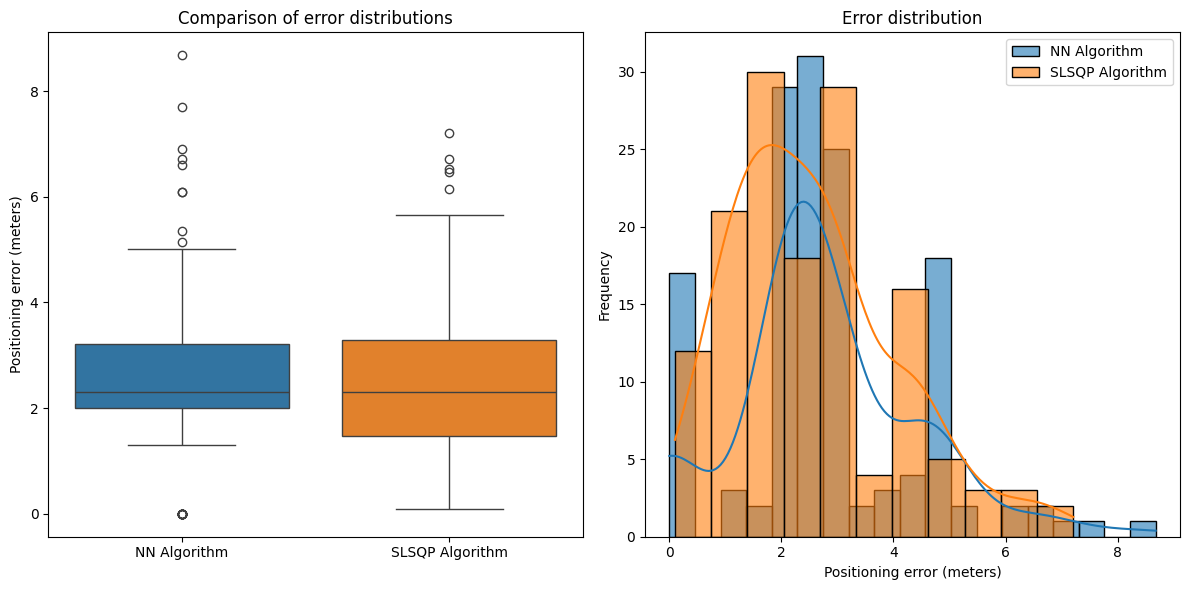

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visual configuration
plt.figure(figsize=(12, 6))

# Comparative boxplot - CORRECTED VERSION
plt.subplot(1, 2, 1)
# Convert to a DataFrame format that seaborn can handle properly
data_for_boxplot = pd.DataFrame({
    'NN Algorithm': nn_error.values,
    'SLSQP Algorithm': optimized_error.values
})
sns.boxplot(data=data_for_boxplot)
plt.ylabel('Positioning error (meters)')
plt.title('Comparison of error distributions')

# Overlapping histogram
plt.subplot(1, 2, 2)
sns.histplot(nn_error, alpha=0.6, label='NN Algorithm', kde=True)
sns.histplot(optimized_error, alpha=0.6, label='SLSQP Algorithm', kde=True)
plt.xlabel('Positioning error (meters)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Error distribution')

plt.tight_layout()
plt.show()